In [1]:
# Have to patch sys.path until we have tighter taucmdr/anaconda integration.
# Need to move towards taucmdr as a conda package.
import os
import sys
try:
    import taucmdr
except ImportError:
    sys.path.insert(0, os.path.join(os.environ['__TAUCMDR_HOME__'], 'packages'))
finally:
    from taucmdr.model.project import Project

In [2]:
#%pylab
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import pandas as pd
import math
import numpy as np
import operator
import time
import re
import collections
#from IPython.display import JSON
# Bokeh
#import bokeh
#from bokeh.plotting import output_notebook, show
#output_notebook()
# plot.ly
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import cufflinks as cf
#cf.go_offline()
# Mayavi
#%gui qt


In [3]:
num_trials = Project.selected().experiment().num_trials
trials = Project.selected().experiment().trials(xrange(0, num_trials))
trial_data = {}
for i in xrange(0, num_trials):
    trial_data[i] = trials[i].get_data()

In [ ]:
#trial0_intervals = trial_data[0][0][0][0].interval_data()
#trial0_intervals.plot(kind='bar')
#plt.show()

In [4]:
start = time.time()
trial_intervals = []
for trial in xrange(0, num_trials):
    for i in xrange(0, len(trial_data[trial])):
        for j in xrange(0, len(trial_data[trial][i])):
            for k in xrange(0, len(trial_data[trial][i][j])):
                trial_intervals.append(trial_data[trial][i][j][k].interval_data())
                #x = trial_data[trial][i][j][k].interval_data()
                #x['percentage'] = x['Exclusive']/x.loc['.TAU application', 'Inclusive']
                #trial_intervals.append(x)
                
expr_intervals = pd.concat(trial_intervals)
expr_intervals.index.names = ['trial', 'rank', 'context', 'thread', 'region']
end = time.time()
print('Time spent constructing dataframe of size %sx%s: %s' %(expr_intervals.shape[0], expr_intervals.shape[1], end-start))

Time spent constructing dataframe of size 863x6: 0.250644922256


In [5]:
# levels: 0=trial, 1=node, 2=context, 3=thread, 4=region name

def filter_regions(dfs, percentage=0.1):
    unstacked_dfs = dfs.unstack(4)
    dfs['percentage'] = unstacked_dfs.loc[:,'Exclusive'].div(unstacked_dfs.loc[:,('Inclusive','.TAU application')], axis=0).stack()
    dfs_filtered = dfs.groupby(level=4).filter(lambda x: x['percentage'].max()>percentage or x.name == '.TAU application')
    print('Filtering all regions with less than %s%% of total runtime reduced number of regions from %s to %s.'%(100*percentage,len(dfs.index.get_level_values(4).unique()), len(dfs_filtered.index.get_level_values(4).unique())))
    return dfs_filtered

def largest_stddev(dfs,n):
    return dfs['Exclusive'].groupby(level=3).std(ddof=0).dropna().sort_values(ascending=False, axis=0)[:n]

def largest_correlation(dfs,n):
    unstacked_dfs = dfs.unstack(4)
    return unstacked_dfs.loc[:,'Exclusive'].corrwith(unstacked_dfs.loc[:,('Inclusive','.TAU application')]).sort_values(ascending=False, axis=0)[:n]

def largest_exclusive(dfs,n):
    return dfs['Exclusive'].groupby(level=4).max().nlargest(n)

def hotspots(dfs, n, flag):
    if flag == 0:
        largest = largest_exclusive(dfs,n)
    elif flag == 1:
        largest = largest_stddev(dfs,n)
    elif flag == 2:
        largest = largest_correlation(dfs,n)
    else:
        print('Invalid flag')
    y = ['exclusive time', 'standard deviation', 'correlation to total runtime']
    print('Hotspot Analysis Summary')
    print('='*80)
    print('The code regions with largest %s are: ' %y[flag])
    for i in xrange(0,n):
        print('%s: %s (%s)' %(i+1, largest.index[i], largest[i]))

n=5

# Hotspot analysis without filtering
nofiltering_start = time.time()
start = time.time()
hotspots(expr_intervals, n, 0)
end = time.time()
print('\nTime spent finding %s most expensive regions: %s\n\n' %(n, end-start))

start = time.time()
hotspots(expr_intervals.loc[1], n, 1)
end = time.time()
print('\nTime spent finding %s regions with largest standard deviation: %s\n\n' %(n, end-start))

start = time.time()
hotspots(expr_intervals, n, 2)
end = time.time()
nofiltering_end = time.time()
print('\nTime spent finding %s regions with highest correlation to total runtime: %s\n\n' %(n, end-start))

# Hotspot analysis with filtering
print('='*80)

filtering_start = time.time()
start = time.time()
filtered_dfs = filter_regions(expr_intervals, 0.05)
end = time.time()
print('\nTime spent filtering the dataframe: %s\n\n' %(end-start))
filtered_dfs

start = time.time()
hotspots(filtered_dfs, n, 0)
end = time.time()
print('\nTime spent finding %s most expensive regions: %s\n\n' %(n, end-start))

start = time.time()
hotspots(filtered_dfs.loc[1], n, 1)
end = time.time()
print('\nTime spent finding %s regions with largest standard deviation: %s\n\n' %(n, end-start))

start = time.time()
hotspots(filtered_dfs, n, 2)
end = time.time()
filtering_end = time.time()
print('\nTime spent finding %s regions with highest correlation to total runtime: %s\n\n' %(n, end-start))

print('Hotspot analysis took %s seconds without filtering and %s seconds with filtering.' %(nofiltering_end-nofiltering_start, filtering_end-filtering_start))

Hotspot Analysis Summary
The code regions with largest exclusive time are: 
1: .TAU application (4765103.0)
2: .TAU application  => [CONTEXT] .TAU application  => [SAMPLE] compute [{/home/skhuvis/workspace/taucmdr/examples/mm/matmult.c} {101}] (2669956.0)
3: [SAMPLE] compute [{/home/skhuvis/workspace/taucmdr/examples/mm/matmult.c} {101}] (2669956.0)
4: .TAU application => MPI_Finalize()   (1484832.0)
5: MPI_Finalize()   (1484832.0)

Time spent finding 5 most expensive regions: 0.00382113456726


Hotspot Analysis Summary
The code regions with largest standard deviation are: 
1: [SAMPLE] multiply [{/home/skhuvis/workspace/taucmdr/examples/mm/matmult.c} {61}] (60005.5)
2: .TAU application  => [CONTEXT] .TAU application  => [SAMPLE] multiply [{/home/skhuvis/workspace/taucmdr/examples/mm/matmult.c} {61}] (60005.5)
3: .TAU application  => [CONTEXT] .TAU application  => [SAMPLE] compute [{/home/skhuvis/workspace/taucmdr/examples/mm/matmult.c} {101}] (49998.5)
4: [SAMPLE] compute [{/home/skhuv

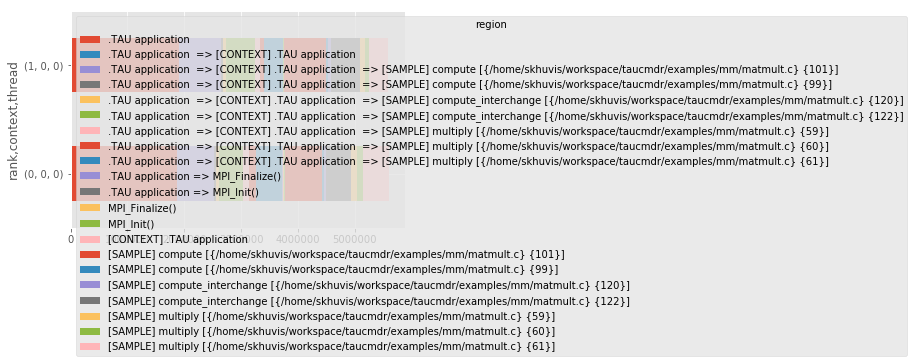

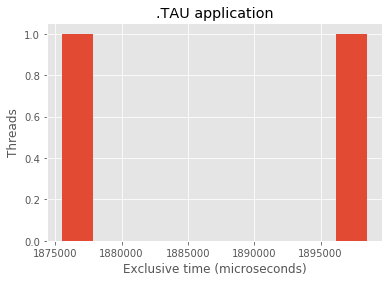

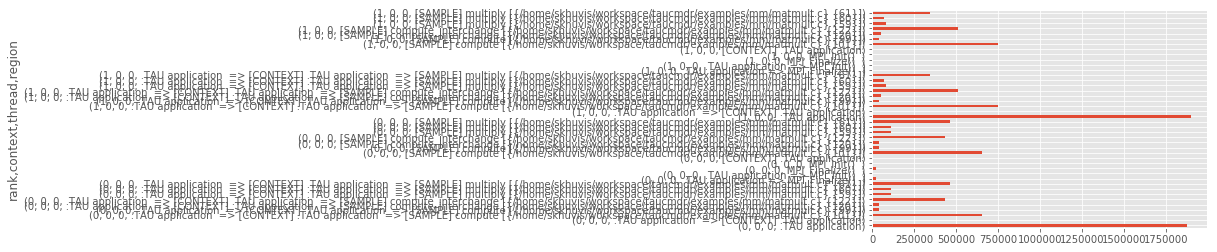


Time spent generating 2D plots: 1.19644379616


In [6]:
# Matplotlib
start = time.time()
#Stacked 2D bar chart for trial 1
expr_intervals.loc[1, 'Exclusive'].unstack().plot.barh(stacked=True, sort_columns=True)
plt.figure()

#Histogram for compute function in trial 7
function = 'void compute(double **, double **, double **, int, int, int) C [{matmult.c} {90,1}-{109,1}]  '
function = '.TAU application'
expr_intervals.loc[(1, slice(None), slice(None), slice(None), function), 'Exclusive'].hist()
plt.xlabel('Exclusive time (microseconds)')
plt.ylabel('Threads')
plt.title(function)
plt.figure()

#Bar chart for each function
expr_intervals.loc[1, 'Exclusive'].plot.barh()
plt.show()
end = time.time()
print('\nTime spent generating 2D plots: %s' %(end-start))

In [ ]:
# Bokeh
start = time.time()
#Stacked 2D bar chart for trial 1
from bokeh.charts import Bar
from bokeh.models import HoverTool
from bokeh.models import GlyphRenderer
df=expr_intervals.loc[1]
df.reset_index(inplace=True)

hover = HoverTool(
        tooltips="""
        <div>
            <span style="font-size: 17px; font-weight: bold;">region: @region</span>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">Exclusive time: @height</span>
        </div>
        """
        )
#p1 = Bar(df, label='rank', values='Exclusive', stack='region', tools=["pan,wheel_zoom,box_zoom,save,reset",hover], legend=False)
p1 = Bar(df, label='rank', values='Exclusive', stack='region', legend=False, tools=["pan,wheel_zoom,box_zoom,save,reset",hover])
#        tooltips=[('region', '@region')])
#p1.select(GlyphRenderer)
#for i in p1.select(GlyphRenderer):
#    print i.data_source.data
show(p1)

#Histogram for compute function in trial 7
from bokeh.charts import Histogram

function = '.TAU application'

#hover = HoverTool(
#        tooltips=[
#            ("index", "$index"),
#            ("(x,y)", "($x, $y)"),
#            ("desc", "@desc"),
#        ])
p2 = Histogram(expr_intervals.loc[(1, slice(None), slice(None), slice(None), function), 'Exclusive'], title=function, bins=10)
p2.xaxis.axis_label = 'Exclusive time (microseconds)'
p2.yaxis.axis_label = 'Threads'
show(p2)

# Vertical Bar chart for each function
df=expr_intervals.loc[0]
#df.index.set_names(['rank', 'context', 'thread', 'region'])
df.index = ["".join(str(x)) for x in df.index.values]
df.index.names = ['region']
df.reset_index(inplace=True)
hover = HoverTool(
        tooltips=[
            ("region", "$x"),
            ("Exclusive (microseconds)", "@height"),
        ])
p3 = Bar(df, label='region', values='Exclusive', legend=False, tools=["pan,wheel_zoom,box_zoom,save,reset",hover])
p3.xaxis.visible = False
show(p3)

# Horizontal Bar chart for each function
#from bokeh.plotting import figure
#df=expr_intervals.loc[0]
#df.index = ["".join(str(x))[:30] for x in df.index.values]
#df.index = [x[3][:30] for x in df.index.values]
#df.index.names = ['region']
#df.reset_index(inplace=True)
#p4 = figure(plot_width=400, plot_height=400)
#p4.hbar(y=df.region.tolist(), height=0.5, right=df.Exclusive.tolist())
#show(p4)

end = time.time()
print('\nTime spent generating 2D plots: %s' %(end-start))

In [ ]:
# plot.ly
#Stacked 2D bar chart for trial 1
#expr_intervals.loc[1, 'Exclusive'].unstack().plot.barh(stacked=True, sort_columns=True)
#plt.figure()
df=expr_intervals.loc[7]
#df1 = df.unstack()
#df = df.unstack()
#df = df.unstack()
#print df1
#df1.iplot(kind='barh', barmode='stack', bargap=.1, filename='cufflinks/barh')
#df['Exclusive'].iplot(kind='barh', barmode='stack', bargap=0.1, filename='cufflinks/barh')
#df = df.unstack()['Exclusive']
#df.index = ["".join(str(x)) for x in df.index.values]
#df.iplot(kind='barh', barmode='stack', bargap=0.1, filename='cufflinks/barh')
df1 = df.unstack()['Exclusive']
df1.index = ["".join(str(x)) for x in df1.index.values]
df1.iplot(kind='barh', barmode='stack', bargap=0.1, filename='cufflinks/barh', legend=False)
#fig = {
#    'data': [
#        #{'x': df.Exclusive, 'y': df.index}
#        Bar(x= df.Exclusive, y= df.index.get_level_values(3), orientation='h')
#    ],
#    'layout': {
#        'xaxis': {'title': 'Thread'},
#        'yaxis': {'title': 'Exclusive time (in microseconds)', 'showticklabels': False},
#        'hovermode' : 'closest'
#    }
#}


#Histogram for compute function in trial 7
#function = 'void compute(double **, double **, double **, int, int, int) C [{matmult.c} {90,1}-{109,1}]  '
#function = '.TAU application'
#expr_intervals.loc[(7, slice(None), slice(None), slice(None), function), 'Exclusive'].hist()
#plt.xlabel('Exclusive time (microseconds)')
#plt.ylabel('Threads')
#plt.title(function)
#plt.figure()
#from plotly.graph_objs import Bar
#bar = Bar(expr_intervals.loc[(7, slice(None), slice(None), slice(None), function), 'Exclusive'])
#py.iplot(bar)

#Bar chart for each function
#from plotly.graph_objs import Bar
#df = expr_intervals.loc[1]
#
#fig = {
#    'data': [
#        #{'x': df.Exclusive, 'y': df.index}
#        Bar(x= df.Exclusive, y= df.index.get_level_values(3), orientation='h')
#    ],
#    'layout': {
#        'xaxis': {'title': 'Exclusive time (microseconds)'},
#        'yaxis': {'title': 'Function', 'showticklabels': False},
#        'hovermode' : 'closest'
#    }
#}
#py.iplot(fig)


In [ ]:
# Parse Callpaths
#import networkx as nx
#from sympy import Symbol, symbols, Dummy, roots, solve
#from bokeh.plotting import figure, gridplot, GridSpec, output_file, show
from graphviz import Digraph


#callgraph = collections.defaultdict(set)
V = set()
E = set()

def addToGraph(function):
    callpath = function.split('=>')
    #nodes.add(callpath[0])
    for i in xrange(0,len(callpath)-1):
        #callgraph[callpath[i]].add(callpath[i+1])
        V.add(callpath[i+1])
        E.add((callpath[i], callpath[i+1]))

def isCallPathFunction(function):
    if '=>' in function:
        return True
    else:
        return False

#def graph_draw(g, layout=nx.circular_layout, node_color="white", text_color="black"):
#    pos = layout(g)
#    labels = [ str(v) for v in g.nodes() ]
#    vx, vy = zip(*[ pos[v] for v in g.nodes() ])
#    xs, ys = [], []
#    for (a, b) in g.edges():
#        x0, y0 = pos[a]
#        x1, y1 = pos[b]
#        xs.append([x0, x1])
#        ys.append([y0, y1])
#    f = figure(plot_width=300, plot_height=300,
#               x_axis_type=None, y_axis_type=None,
#               outline_line_color=None,
#               tools=[], toolbar_location=None)
#    f.multi_line(xs, ys, line_color="black")
#    f.circle(vx, vy, size=16, line_color="black", fill_color=node_color)
#    f.text(vx, vy, text=labels, text_color=text_color,
#           text_font_size="10px", text_align="center", text_baseline="middle")
#    return f

def draw_graph(V, E):
    g = Digraph()
    for v in V:
        g.node(v)
    for e in E:
        g.edge(e[0], e[1])
    return g
    
for region in expr_intervals.index.get_level_values(4).unique():
    #print '%s: %s' %(region, isCallPathFunction(region))
    if isCallPathFunction(region):
        addToGraph(region)



g = draw_graph(V, E)
g

In [ ]:
# Table with links
from IPython.core.display import display, HTML, display_html

_location_re = re.compile(r'\{(.*)\} {(\d+),(\d+)}-{(\d+),(\d+)}')
def parse_region(region):
    func = region.split('=>')[-1]
    loc = re.search(r'\[(.*)\]', func)
    if loc:
        location = loc.group(1)
        match = _location_re.match(location)
        if match:
            return match.group(1)
    if '[SAMPLE]' in func:
        loc = re.search(r'\[\{(.*)\} \{(\d+)\}\]', func)
        if loc:
            return loc.group(1)

def add_link(multiindex):
    link = parse_region(multiindex[4])
    if link:
        return (multiindex[0],multiindex[1],multiindex[2],multiindex[3],'<a href="{0}">{1}</a>'.format((link), multiindex[4]))
    else:
        return multiindex

expr_intervals_link = expr_intervals.copy()
expr_intervals_link.index = expr_intervals_link.index.map(lambda x: add_link(x))
HTML(expr_intervals_link.to_html(escape=False))

In [ ]:
# Collapsible table
#JSON(expr_intervals.loc[(0,0,0,0)].to_json(orient='index'))

In [ ]:
def remove_line_no(index):
    end = index[4].rfind('} {')
    if end == -1:
        end = index[4].rfind(' ADDR ')
    if end == -1:
        return (index[0], index[1], index[2], index[3], index[4])
    name = index[4][:end]+'}]'
    return (index[0], index[1], index[2], index[3], name)
    
def summary_name(function_name):
    if ('[SAMPLE]' in function_name or '[disbled UNWIND]' in function_name) and (('UNRESOLVED' not in function_name) or ('UNRESOLVED' in function_name and 'ADDR' in function_name)):
        index = function_name.rfind('[SAMPLE]')
        if index == -1:
            index = function_name.rfind('[UNWIND]')
        if index == -1:
            return function_name
        else:
            new_function = function_name[:index] + '[SUMMARY]' + function_name[index+8:]
            return new_function
    else:
        return function_name
    
def add_summary(df):
    gr = df.groupby(by=remove_line_no)
    sum_rows = []
    for name, group in gr:
        if group['Exclusive'].count()>1:
            sum_row = np.sum(group)
            sum_row.name = (name[0], name[1], name[2], name[3], summary_name(name[4]))
            sum_rows.append(sum_row)

    sum_rows_df = pd.DataFrame(sum_rows)
    df = pd.concat([df, sum_rows_df])
    return df

expr_intervals_sample = expr_intervals.copy()
#expr_intervals_sample.index = expr_intervals_sample.index.map(lambda x: add_summary(x))
expr_intervals_sample = add_summary(expr_intervals_sample)

hotspots(expr_intervals_sample.loc[7], n, 1)
hotspots(expr_intervals_sample, 5, 0)

In [ ]:
#from pivottablejs import pivot_ui
#pivot_ui(expr_intervals)

In [7]:
#3D Plot
start = time.time()

from __future__ import division, print_function
from pythreejs import *
from IPython.display import display
from ipywidgets import HTML, Text
from traitlets import link
import random
import math
import numpy as np
height = 2
children = []

def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return r, g, b


def add_box(pos, height, color):
    #height = 1
    children.append( Mesh(geometry=BoxGeometry(width=0.95, height=height, depth=0.95), 
                                    material=LambertMaterial(color=color),
                                    position=pos))

def add_region(text, position, size=19):
    t = TextTexture(string=text, color='black', size=size, squareTexture=False)
    #sm = SpriteMaterial(map=text)
    #sp = Sprite(material=sm, position = position, scaleToTexture=True, scale=[.25, .25, .25], up=[1,0,0])
    material = LambertMaterial(map=t)
    geometry = PlaneGeometry(width=size)
    sp = Mesh(geometry=geometry, material=material, position=position)
    return sp

def add_rank(text, position):
    t = TextTexture(string=text, color='black', size=15, squareTexture=False)
    #sm = SpriteMaterial(map=text)
    #sp = Sprite(material=sm, position = position, scaleToTexture=True, scale=[.25, .25, .25], up=[1,0,0])
    material = LambertMaterial(map=t)
    geometry = PlaneGeometry(width=1)
    sp = Mesh(geometry=geometry, material=material, position=position)
    return sp

df = expr_intervals.loc[1].unstack()['Exclusive']
max_val = df.values.max()
row_id = 0
ii = 0
for col in df.columns.values:
    #children.append(add_region(text=col, position=(-10,0,ii)))
    ii = ii + 1

for row in df.itertuples(index=True):
    #color = "#%06x" % random.randint(0, 0xFFFFFF)
    #add text for thread and region
    #children.append(add_rank(text=str(row[0]), position=(row_id,0,-1)))
    for region_id in xrange(1, len(row)):
        height = row[region_id] / max_val
        color = "#%02X%02X%02X" %rgb(0, 1, height)
        #ii = ii + 1
        add_box([row_id, height/2, region_id-1], height, color)
        #row_idprint('%s, %s' %(row_id, region_id))
    row_id = row_id + 1


children.append(AmbientLight(color='#777777'))
scene = Scene(children=children)
c = PerspectiveCamera(position=[-5, 10, -5], up=[0, 1, 0],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])
renderer = Renderer(camera=c, 
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])

display(renderer)
end = time.time()
print('\nTime spent generating 3D plot: %s' %(end-start))

Widget Javascript not detected.  It may not be installed or enabled properly.



Time spent generating 3D plot: 0.419450998306
